In [1]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_V6_TN")
output_folder.mkdir(exist_ok=True)

image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_1.png")
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_3.png")
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_4.png")
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_5.png")
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_6.png")
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_7.png")
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_8.png") # ซ้ำกับ 7
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_9.png") # จับตารางได้แต่พังตอน pt
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_10.png") # ลบเส้นตารางไม่หมดตรงรหัสวิชา
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_11.png") # ภาพใหญ่เกินไป
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_12.png") # ตารางไม่ตรง
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_13.png") # ติดลอยปั้มหมึก
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_14.png")
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_15.png")

if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

denoised = cv2.bilateralFilter(image, d=9, sigmaColor=100, sigmaSpace=100) # จำกัด noise
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

binary_gaussian = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=51, 
    C=21 #21
)

cv2.imwrite(f"{output_folder}/original.png", image)
cv2.imwrite(f"{output_folder}/denoised.png", denoised)
cv2.imwrite(f"{output_folder}/gray.png", gray_img)
cv2.imwrite(f"{output_folder}/binary_g.png", binary_gaussian)

True

In [2]:
def split_grade_table_and_students(binary_img, denoised):
    
    # แยกตาราง
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
    areas = [stat[4] for stat in stats]  # ดึงค่า area
    sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
    second_max_area = sorted_areas[1]  # ค่าอันดับ 2
    second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม
    table_position = stats[second_max_area_index]
    x, y, w, h, area = table_position
    table_img = binary_img[y:y+h, x:x+w]
    table_original_img = denoised[y:y+h, x:x+w]

    # ข้อมูลนักเรียน
    #x_start = int((x+w) * 0.40) # ความกว้าง 40% ของตาราง
    x_end = int((x+w) * 0.85) # ความกว้าง 85% ของตาราง
    x_split_half = int((x+w) * 0.38) # ความกว้าง 38% ของตาราง

    student_info_img = binary_img[:y, :x_end]
    student_info_fh_img = binary_img[:y, :x_split_half] # ครึ่งแรก
    student_info_sh_img = binary_img[:y, x_split_half:x_end] # ครึ่งหลัง

    return table_img, student_info_img, student_info_fh_img, student_info_sh_img, table_original_img

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        #print(area)
        if area > 1000:
            #print("มา")
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area

    return biggest

def persective_transformation(table_binary_img, table_original_img):

    # ค้นหาคอนทัวร์
    contours, hierarchy = cv2.findContours(table_binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #contours, hierarchy = cv2.findContours(table_binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # ค้นหาสี่เหลี่ยมที่ใหญ่ที่สุด
    biggest = biggest_contour(contours)

    points = biggest.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points

    # Euclidean Distance Formula
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    rigth_height = np.sqrt(((top_left[0] - bottom_right[0]) ** 2) + ((top_left[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    # Output image size
    #max_width = max(int(bottom_width), int(top_width))
    expand_width = round(max(int(bottom_width), int(top_width)) * 0.4)
    max_width = max(int(bottom_width), int(top_width)) + expand_width
    max_height = max(int(rigth_height), int(left_height))

    # Desird points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformaxtion
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_out = cv2.warpPerspective(table_binary_img.copy(), matrix, (max_width, max_height))
    img_original_out = cv2.warpPerspective(table_original_img.copy(), matrix, (max_width, max_height))

    return img_out, img_original_out

def hough_line_transform(binary_image, table_original_persective_img, grid_img):

    # 1) ใช้ HoughLinesP ตรวจจับเส้น
    #    - พารามิเตอร์ที่สำคัญ: threshold, minLineLength, maxLineGap
    lines = cv2.HoughLinesP(
        binary_image,
        rho=1,
        theta=np.pi/180,
        threshold=100,      # ต้องปรับจูน
        minLineLength=700,  # ต้องปรับจูน
        maxLineGap=10     # ต้องปรับจูน
    )

    # 2) สร้าง mask (เป็นภาพดำล้วน ขนาดเท่ากับต้นฉบับ)
    line_mask = np.zeros_like(binary_image)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # วาดเส้นสีขาวลงใน mask (ปรับ thickness ตามความหนาเส้นในภาพ)
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)

    # 4) เราจะเอา mask นี้มาช่วยลบเส้นในภาพ
    #    วิธีง่าย ๆ คือการเอา thresh ที่เป็น binary_inv มาลบด้วย mask (bitwise)
    #    หรืออาจใช้เทคนิค inpaint บนภาพสี

    # วิธีที่ 4.1: ลบตรง ๆ จาก thresh ก่อน (ซึ่งเป็น Binary แล้ว)
    table_without_lines = cv2.bitwise_and(binary_image, cv2.bitwise_not(line_mask))
    table_without_lines_2 = cv2.bitwise_and(table_without_lines, cv2.bitwise_not(grid_img))


    # หรือ วิธีที่ 4.2: ลอง inpaint บนภาพจริงสี (img)
    #    โดยปกติ inpaint จะต้องการ mask สีขาว บริเวณที่ต้องการซ่อมแซม
    #    ซึ่ง line_mask ของเราพอดีอยู่แล้ว
    inpainted = cv2.inpaint(table_original_persective_img, line_mask, 3, cv2.INPAINT_TELEA)

    #kernel = np.ones((20, 15), np.uint8)
    #final_dilate = cv2.dilate(image_without_lines, kernel, iterations=1)


    # เนื่องจาก thresh เป็น invert (พื้นดำ ตัวหนังสือขาว)
    # ถ้าอยากกลับด้านให้พื้นขาว ตัวหนังสือดำก็ทำ bitwise_not อีกที
    #final = cv2.bitwise_not(image_without_lines)
    cv2.imwrite(f"{output_folder}/line_mask.png", line_mask)
    cv2.imwrite(f"{output_folder}/image_without_lines.png", table_without_lines)
    cv2.imwrite(f"{output_folder}/image_without_lines_2.png", table_without_lines_2)
    #cv2.imwrite(f"{output_folder}/final_dilate.png", final_dilate)
    cv2.imwrite(f"{output_folder}/inpainted.png", inpainted)

    return line_mask, table_without_lines, table_without_lines_2

def cells_detect(grid_lines):
    # ขั้นตอนที่ 1: Invert ภาพ
    inverted = cv2.bitwise_not(grid_lines) # (เพื่อให้พื้นที่ดำ (ช่องตาราง) กลายเป็นสีขาว, ส่วนเส้นขาวจะเป็นสีดำ)

    # ขั้นตอนที่ 2: Erode พื้นที่ขาวเล็กน้อย เพื่อลดการติดเส้น
    kernel = np.ones((3, 3), np.uint8) # สร้าง kernel เล็ก ๆ เพื่อ erode
    eroded = cv2.erode(inverted, kernel, iterations=0)

    #cv2.imwrite(f"{output_folder}/eroded.png", eroded)

    # ขั้นตอนที่ 3: Find Contours (หาพื้นที่สีขาว ซึ่งเป็นรูปทรงของช่องตาราง)
    #contours, hierarchy = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = filter(lambda c: cv2.boundingRect(c)[2] > 40, contours)  # กรอง w > 10
    contours = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[3], reverse=True)[:10] # เรียงลำดับ contours ตามค่า h (ความสูง) จากมากไปน้อย
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0], reverse=False)  # เรียงลำดับ contours ตามค่า x จากน้อยไปมาก
 
    # ขั้นตอนที่ 4: วนลูปดูผลลัพธ์ของ Contours แต่ละอัน

    output = cv2.cvtColor(grid_lines.copy(), cv2.COLOR_GRAY2BGR)  # ไว้สำหรับวาดกรอบ

    cell_contours = []

    for i, cnt in enumerate(contours):
        # หา bounding box ของ contour
        x, y, w, h = cv2.boundingRect(cnt)
        area = int(cv2.contourArea(cnt))
        cell_contours.append([x, y, w, h, area])

        # วาดสี่เหลี่ยมครอบลงบน output เพื่อดู
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
        print(f"Contour #{i}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")

    cv2.imwrite(f"{output_folder}/Contours.png", output)

    return cell_contours

def create_grid_image(table_img,
                      col_percentages=[8, 40, 43, 46.33, 50, 58, 90, 93, 96.33, 100],
                      #col_percentages=[8, 39, 43, 46.33, 50, 58, 89, 93, 96.33, 100],
                      row_percentages=[9.22, 100],
                      grid_color=(255, 255, 255),
                      vertical_line_thickness_percent=0.005,   # 0.33% ของความกว้างภาพสำหรับเส้นแนวตั้ง
                      horizontal_line_thickness_percent=0.008, # 0.33% ของความกว้างภาพสำหรับเส้นแนวนอน
                      bg_color=(0, 0, 0),
                      return_binary=True,
                      threshold_val=127):
    
    """
    สร้างภาพตารางที่มีขนาด width x height โดยแบ่งคอลัมน์และแถวตามเปอร์เซ็นต์ที่กำหนด
    ความหนาของเส้นจะถูกคำนวณเป็นเปอร์เซ็นต์ของความกว้างของภาพ
    ถ้า return_binary=True จะทำการแปลงภาพเป็น binary (ขาวดำ) โดยใช้ threshold ที่กำหนด

    :param width: ความกว้างของภาพ (พิกเซล)
    :param height: ความสูงของภาพ (พิกเซล)
    :param col_percentages: รายการเปอร์เซ็นต์สำหรับขอบขวาของแต่ละคอลัมน์ (เรียงจากน้อยไปมาก; คอลัมน์สุดท้าย = 100%)
    :param row_percentages: รายการเปอร์เซ็นต์สำหรับขอบล่างของแต่ละแถว (เรียงจากน้อยไปมาก; แถวสุดท้าย = 100%)
    :param grid_color: สีของเส้นตารางในรูปแบบ (B, G, R)
    :param line_thickness_percent: ความหนาของเส้นในรูปแบบเปอร์เซ็นต์ของความกว้างภาพ
    :param bg_color: สีพื้นหลังของภาพ
    :param return_binary: ถ้า True จะคืนภาพในรูปแบบ binary (หลัง threshold) มิฉะนั้นคืนค่าเป็น BGR image
    :param threshold_val: ค่าที่ใช้ threshold เมื่อแปลงเป็นภาพ binary
    :return: ภาพตารางในรูปแบบ binary (ถ้า return_binary=True) หรือ BGR image (ถ้า False)
    """

    height, width, = table_img.shape  # ได้ค่า (สูง, กว้าง)

    image = np.full((height, width, 3), bg_color, dtype=np.uint8)
    
    # คำนวณความหนาของเส้นสำหรับแต่ละแนว (อย่างน้อย 1 พิกเซล)
    vertical_thickness = max(1, int(width * vertical_line_thickness_percent))
    horizontal_thickness = max(1, int(width * horizontal_line_thickness_percent))
    
    # คำนวณตำแหน่งเส้นแนวตั้ง (x_positions)
    col_fracs = [p / 100.0 for p in col_percentages]
    x_positions = [0] + [int(width * p) for p in col_fracs]
    
    # คำนวณตำแหน่งเส้นแนวนอน (y_positions)
    row_fracs = [p / 100.0 for p in row_percentages]
    y_positions = [0] + [int(height * p) for p in row_fracs]
    
    # วาดเส้นตารางแนวตั้งโดยใช้ความหนาที่คำนวณสำหรับแนวตั้ง
    for x in x_positions:
        cv2.line(image, (x, 0), (x, height), grid_color, vertical_thickness)
    
    # วาดเส้นตารางแนวนอนโดยใช้ความหนาที่คำนวณสำหรับแนวนอน
    for y in y_positions:
        cv2.line(image, (0, y), (width, y), grid_color, horizontal_thickness)
    
    # แปลงภาพเป็น binary หากต้องการ
    if return_binary:
        # แปลงเป็น grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # ใช้ threshold เพื่อแปลงเป็นภาพ binary
        _, binary_image = cv2.threshold(gray, threshold_val, 255, cv2.THRESH_BINARY)
        return binary_image
    else:
        return image

table_img, student_info_img, student_info_fh_img, student_info_sh_img, table_original_img = split_grade_table_and_students(binary_gaussian, denoised)
table_persective_img, table_original_persective_img = persective_transformation(binary_gaussian, denoised)
grid_img = create_grid_image(table_persective_img)
line_mask, table_without_lines, table_without_lines_2 = hough_line_transform(table_persective_img, table_original_persective_img, grid_img)

cell_contours = cells_detect(grid_img)

cv2.imwrite(f"{output_folder}/table_img.png", table_img)
cv2.imwrite(f"{output_folder}/student_info_img.png", student_info_img)
cv2.imwrite(f"{output_folder}/table_original_img.png", table_original_img)
cv2.imwrite(f"{output_folder}/table_persective_img.png", table_persective_img)
cv2.imwrite(f"{output_folder}/table_original_persective_img.png", table_original_persective_img)
cv2.imwrite(f"{output_folder}/student_info_fh_img.png", student_info_fh_img)
cv2.imwrite(f"{output_folder}/student_info_sh_img.png", student_info_sh_img)
cv2.imwrite(f"{output_folder}/grid_img.png", grid_img)

Contour #0: bounding box = (x=6, y=195, w=161, h=1810, area=289440)
Contour #1: bounding box = (x=178, y=195, w=678, h=1810, area=1224693)
Contour #2: bounding box = (x=867, y=195, w=53, h=1810, area=94068)
Contour #3: bounding box = (x=931, y=195, w=61, h=1810, area=108540)
Contour #4: bounding box = (x=1003, y=195, w=68, h=1810, area=121203)
Contour #5: bounding box = (x=1082, y=195, w=161, h=1810, area=289440)
Contour #6: bounding box = (x=1254, y=195, w=678, h=1810, area=1224693)
Contour #7: bounding box = (x=1943, y=195, w=54, h=1810, area=95877)
Contour #8: bounding box = (x=2008, y=195, w=60, h=1810, area=106731)
Contour #9: bounding box = (x=2079, y=195, w=69, h=1810, area=123012)


True

# แบ่งส่วนตาราง

In [3]:
def crop_image(cell_contours, table_without_lines):
    cell_images = []
    for idx, cell_position in enumerate(cell_contours):
        x, y, w, h, area = cell_position
        crop_img = table_without_lines[y:y+h, x:x+w]
        cell_images.append(crop_img)
        cv2.imwrite(f"{output_folder}/cell_images/crop_img_{idx}.png", crop_img)
        #print(f"Contour #{idx}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")

    return cell_images
        
cell_images = crop_image(cell_contours, table_without_lines_2)

cell_subject_code_img = cell_images[0]
cell_subject_name_img = cell_images[1]
cell_credit_img = cell_images[2]
cell_academic_results_img = cell_images[3]
cell_subject_code_img_2 = cell_images[5]
cell_subject_name_img_2 = cell_images[6]
cell_credit_img_2 = cell_images[7]
cell_academic_results_img_2 = cell_images[8]

In [4]:
def detect_text_group_in_cell(cell_img, mode=0, calculate_line_stats=None):
    text_group_images = []

    kernel_open = np.ones((4, 4), np.uint8)
    #kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    remove_noise = cv2.morphologyEx(cell_img, cv2.MORPH_OPEN, kernel_open, iterations=1)

    #cv2.imwrite(f"{output_folder}/cell_images/remove_noise.jpg", remove_noise)

    kernel = np.ones((3, 13), np.uint8)
    group_text_img = cv2.dilate(remove_noise, kernel, iterations=2)
    rgb_image = cv2.cvtColor(cell_img.copy(), cv2.COLOR_GRAY2RGB)

    #plt.figure(figsize=(15, 15))
    #plt.imshow(group_text, cmap="gray")

    if(mode == 1):
        # ใช้ Connected Component Analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(group_text_img, connectivity=8)

        text_stats = stats[1:]
        sorted_indices = np.argsort(text_stats[:, 1])  # จัดเรียงตามค่า y (คอลัมน์ที่ 1)
        sorted_stats = text_stats[sorted_indices]

        # ใช้ Boolean Indexing เพื่อเอา noise ออก 
        sorted_stats = sorted_stats[sorted_stats[:, 4] >= 2000]
        calculate_line_stats = []

        for idx_stat, stat in enumerate(sorted_stats):
            x, y, w, h, area = stat
            #print(f"CCA #{idx_stat}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            if idx_stat == (len(sorted_stats)-1):
                #print("เข้าเงื่อนลำดัยสุดท้าย",idx_stat)
                x, y, w, h, area = stat
                new_y = round(y-(h/2))
                new_h = round(h+(h*0.8))
                calculate_line_stats.append([x, new_y, w, new_h, area])
            else:
                current_stat = stat
                next_stat = sorted_stats[idx_stat+1]

                distance = next_stat[1] - current_stat[1]
                line_spacing = distance/current_stat[3]

                if line_spacing > 3 and line_spacing <= 5: # เป็นชื่อวิชาที่มีความยาวมากกว่า 1 บรรทัด
                    #print("เข้าเงื่อนไข มากกว่า 1 บรรทัด")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+(h*2.5))
                    calculate_line_stats.append([x, new_y, w, new_h, area])

                elif line_spacing > 6: # เป็นช่องว่างที่ไม่มีวิชา
                    #print("เข้าเงื่อนไข เป็นช่องว่างที่ไม่มีวิชา")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+h)
                    calculate_line_stats.append([x, new_y, w, new_h, area])
                
                else: # เป็นชื่อวิชาที่มีความยาวแค่ว่า 1 บรรทัด
                    #print("เข้าเงื่อนไข 1 บรรทัด")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+(h*0.8))
                    calculate_line_stats.append([x, new_y, w, new_h, area])

        calculate_line_stats = np.array(calculate_line_stats) 

            #print(f"CCA #{idx_stat}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            #cv2.rectangle(rgb_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #cv2.imwrite(f"{output_folder}/cell_images/cca.jpg", rgb_image)

    text_stats = sorted_stats if mode == 1 else calculate_line_stats

    
    for idx, stats in enumerate(text_stats): # เก็บภาพกลุม
        x, y, w, h, area = stats
   
        if mode == 1:
            cca_img = cell_img[y:y+h, x:x+w]
        if mode == 2:
            #print(f"stats #{idx}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            if idx == 0: # ดักบัค crop รูปเกินขอบเขต
                cca_img = cell_img[y+5:y+h, :]
            elif idx == (len(text_stats)-1):
                cca_img = cell_img[y:y+h-5, :]
            else:
                cca_img = cell_img[y:y+h, :]
        text_group_images.append(cca_img)

        # หาขนาดของภาพ (ความกว้างและความสูง)
        image_height, image_width, _ = rgb_image.shape  # ได้ค่า (สูง, กว้าง, ช่องสี)
        cv2.rectangle(rgb_image, (x, y), (image_width, y + h), (0, 255, 0), 1)

    if mode == 1:
        return text_group_images, calculate_line_stats, rgb_image
    else:
        return text_group_images, rgb_image

# ตารางครึ่งแรก
text_subject_code_images, calculate_line_stats_1, subject_code_img = detect_text_group_in_cell(cell_subject_code_img, 1)
text_subject_name_images, subject_name_img = detect_text_group_in_cell(cell_subject_name_img, 2, calculate_line_stats_1)
text_credit_images, credit_img = detect_text_group_in_cell(cell_credit_img, 2, calculate_line_stats_1)
text_academic_results_images, academic_results_img = detect_text_group_in_cell(cell_academic_results_img, 2, calculate_line_stats_1)

# ตารางครึ่งหลัง
text_subject_code_images_2, calculate_line_stats_2, subject_code_img_2 = detect_text_group_in_cell(cell_subject_code_img_2, 1)
text_subject_name_images_2, subject_name_img_2 = detect_text_group_in_cell(cell_subject_name_img_2, 2, calculate_line_stats_2)
text_credit_images_2, credit_img_2 = detect_text_group_in_cell(cell_credit_img_2, 2, calculate_line_stats_2)
text_academic_results_images_2, academic_results_img_2 = detect_text_group_in_cell(cell_academic_results_img_2, 2, calculate_line_stats_2)

cv2.imwrite(f"{output_folder}/cell_images/cca_subject_code_img.jpg", subject_code_img)
cv2.imwrite(f"{output_folder}/cell_images/cca_subject_name_img.jpg", subject_name_img)
cv2.imwrite(f"{output_folder}/cell_images/cca_credit_img.jpg", credit_img)
cv2.imwrite(f"{output_folder}/cell_images/cca_academic_results_img.jpg", academic_results_img)
cv2.imwrite(f"{output_folder}/cell_images/cca_subject_code_img_2.jpg", subject_code_img_2)
cv2.imwrite(f"{output_folder}/cell_images/cca_subject_name_img_2.jpg", subject_name_img_2)
cv2.imwrite(f"{output_folder}/cell_images/cca_credit_img_2.jpg", credit_img_2)
cv2.imwrite(f"{output_folder}/cell_images/cca_academic_results_img_2.jpg", academic_results_img_2)
#cv2.imwrite(f"{output_folder}/cell_images/cca_text_subject_name_images.jpg", subject_name_img)


True

In [ ]:
for idx, img in enumerate(text_subject_code_images):
    print(idx)
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap="gray")

### จับข้อความย่อยในกลุ่มข้อความของ cell ตาราง

In [6]:
from numpy import append

def detect_sub_text_in_group(binary_image):

    text_group = []
    for idx, img in enumerate(binary_image):
        #print(idx+1)

        #plt.figure(figsize=(5,5))
        #plt.imshow(img, cmap="gray")
        #plt.title(f"binary_image")
        #plt.show()

        sub_text_images = []

        kernel_open = np.ones((3, 3), np.uint8)
        remove_noise = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open, iterations=1)

        #plt.figure(figsize=(5,5))
        #plt.imshow(remove_noise, cmap="gray")
        #plt.title(f"remove_noise")
        #plt.show()

        # เช็คว่าภาพเป็นสีดำทั้งหมดหรือไม่
        if not np.any(remove_noise):  # ถ้าค่าพิกเซลทั้งหมดเป็น 0 (ดำสนิท)
            print("ภาพเป็นสีดำทั้งหมด")
            sub_text_images.append(remove_noise)
            #return sub_text_images 
        
        else:
            kernel = np.ones((6, 6), np.uint8)
            dummy_image = cv2.dilate(remove_noise, kernel, iterations=2)

            #plt.figure(figsize=(5,5))
            #plt.imshow(dummy_image, cmap="gray")
            #plt.title(f"dummy_image")
            #plt.show()

            # ใช้ Connected Component Analysis
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)
            char_stats = stats[1:] # ข้าม Background (index 0)
            sorted_indices = np.argsort(char_stats[:, 0]) # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
            sorted_stats = char_stats[sorted_indices]

            # ใช้ Boolean Indexing เพื่อเอา noise ออก 
            sorted_stats = sorted_stats[sorted_stats[:, 4] >= 200]

            for idx, stats in enumerate(sorted_stats):
                #x, y, w, h, area = stats[i]
                x, y, w, h, area = stats

                cca_img = img[y:y+h, x:x+w]
                sub_text_images.append(cca_img)

        text_group.append(sub_text_images)

    return text_group
    
text_group_subject_code = detect_sub_text_in_group(text_subject_code_images)
text_group_subject_name = detect_sub_text_in_group(text_subject_name_images)
text_group_credit = detect_sub_text_in_group(text_credit_images)
text_group_academic_results = detect_sub_text_in_group(text_academic_results_images)

text_group_subject_code_2 = detect_sub_text_in_group(text_subject_code_images_2)
text_group_subject_name_2 = detect_sub_text_in_group(text_subject_name_images_2)
text_group_credit_2 = detect_sub_text_in_group(text_credit_images_2)
text_group_academic_results_2 = detect_sub_text_in_group(text_academic_results_images_2)



ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด


In [ ]:
# ทดสอบดูรูป
for idx_g, text_group in enumerate(text_group_subject_code):
    print(f"text {idx_g+1}")
    for idx_s, sub_text in enumerate(text_group):
        plt.figure(figsize=(4,4))
        plt.imshow(sub_text, cmap="gray")
        plt.title(f"sub text {idx_s+1}")
        plt.show()

## จับตัวอักษร

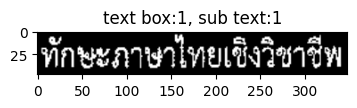

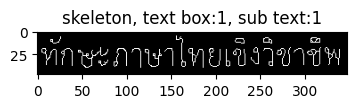

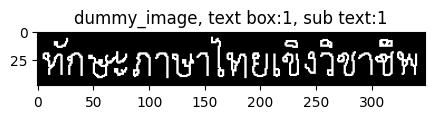

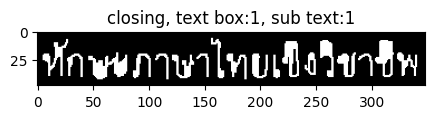

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix_wrap.cpp:81: error: (-215:Assertion failed) 0 <= i && i < (int)v.size() in function 'cv::_InputArray::getMat_'


In [ ]:
from turtle import width


def percentage_difference(value1, value2):
    return abs(value1 - value2) / value1 * 100

def detect_one_level_of_char(text_group):
    text_group_char = []
    for idx_g, text_g in enumerate(text_group):

        sub_text_char = []
        for idx_s, sub_text in enumerate(text_g):

            '''
            plt.figure(figsize=(3, 3))
            plt.imshow(sub_text, cmap="gray")
            plt.title(f"text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()
            '''

            #skeleton = cv2.ximgproc.thinning(sub_text, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
            skeleton_guohall = cv2.ximgproc.thinning(sub_text, thinningType=cv2.ximgproc.THINNING_GUOHALL)

            '''
            plt.figure(figsize=(3, 3))
            plt.imshow(skeleton_guohall, cmap="gray")
            plt.title(f"skeleton, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()
            '''

            #kernel_open = np.ones((2, 2), np.uint8)
            kernel = np.ones((2, 2), np.uint8)
            #opening = cv2.morphologyEx(skeleton, cv2.MORPH_OPEN, kernel=kernel_open, iterations=2)
            #closing = cv2.morphologyEx(skeleton, cv2.MORPH_CLOSE, kernel=kernel_open, iterations=2)
            dummy_image = cv2.dilate(skeleton_guohall, kernel, iterations=1)

            '''
            plt.figure(figsize=(3, 3))
            plt.imshow(dummy_image, cmap="gray")
            plt.title(f"dummy_image, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()
            '''

            rgb_image = cv2.cvtColor(sub_text.copy(), cv2.COLOR_GRAY2RGB)
            contours, hierarchy = cv2.findContours(dummy_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            sorted_contours = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

            char_images = []
            for idx_c, cnt in enumerate(sorted_contours):

                x, y, w, h = cv2.boundingRect(cnt)
                contour_area = cv2.contourArea(cnt)

                left_margin_percent   = 0.2   # ขยายด้านซ้าย 10% ของความกว้าง bounding box
                right_margin_percent  = 0.0    # ขยายด้านขวา 10%
                top_margin_percent    = 0.15    # ขยายด้านบน 10% ของความสูง bounding box
                bottom_margin_percent = 0.1    # ขยายด้านล่าง 10%

                # คำนวณ margin ในหน่วยพิกเซล
                left_margin   = int(w * left_margin_percent)
                right_margin  = int(w * right_margin_percent)
                top_margin    = int(h * top_margin_percent)
                bottom_margin = int(h * bottom_margin_percent)

                # คำนวณตำแหน่ง bounding box ใหม่
                new_x  = max(x - left_margin, 0)
                new_y  = max(y - top_margin, 0)
                img_height, img_width = sub_text.shape
                new_x2 = min(x + w + right_margin, img_width)   # new_x2 คือพิกัดขวาสุดของกรอบ
                new_y2 = min(y + h + bottom_margin, img_height)   # new_y2 คือพิกัดล่างสุดของกรอบ

                cropped_img = sub_text[new_y:new_y2, new_x:new_x2]
                char_images.append(cropped_img)

                cv2.rectangle(rgb_image, (new_x, new_y), (new_x2, new_y2), (0, 255, 0), 1)
                #print(f"Contour #{idx_c}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={contour_area})")

            sub_text_char.append(char_images)
            '''
            plt.figure(figsize=(3, 3))
            plt.imshow(rgb_image, cmap="gray")
            plt.title(f"Contour, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()
            '''
        text_group_char.append(sub_text_char)
    return text_group_char

def detect_char(text_group):
    text_group_char = []
    for idx_g, text_g in enumerate(text_group):

        sub_text_char = []
        for idx_s, sub_text in enumerate(text_g):
            
            plt.figure(figsize=(4, 4))
            plt.imshow(sub_text, cmap="gray")
            plt.title(f"text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()
            

            skeleton = cv2.ximgproc.thinning(sub_text, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
            #skeleton_guohall = cv2.ximgproc.thinning(sub_text, thinningType=cv2.ximgproc.THINNING_GUOHALL)

            
            plt.figure(figsize=(4, 4))
            plt.imshow(skeleton, cmap="gray")
            plt.title(f"skeleton, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()
            

            #kernel_open = np.ones((2, 2), np.uint8)
            kernel = np.ones((2, 2), np.uint8)
            kernel_closing = np.ones((10, 1), np.uint8)
            #opening = cv2.morphologyEx(skeleton, cv2.MORPH_OPEN, kernel=kernel_open, iterations=2)
            dummy_image = cv2.dilate(skeleton, kernel, iterations=1)
            closing = cv2.morphologyEx(dummy_image, cv2.MORPH_CLOSE, kernel=kernel_closing, iterations=1)

            
            plt.figure(figsize=(5, 5))
            plt.imshow(dummy_image, cmap="gray")
            plt.title(f"dummy_image, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()

            plt.figure(figsize=(5, 5))
            plt.imshow(closing, cmap="gray")
            plt.title(f"closing, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()
            

            rgb_image = cv2.cvtColor(sub_text.copy(), cv2.COLOR_GRAY2RGB)
            contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            sorted_contours = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

            char_images = []
            for idx_c, cnt in enumerate(sorted_contours):

                x, y, w, h = cv2.boundingRect(cnt)
                contour_area = cv2.contourArea(cnt)

                char_height, char_width = h, w

                mask = np.zeros((char_height, char_width), dtype=np.uint8)

                rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

                # วาด contour ลงบน mask โดยเติมเต็มด้วยสีขาว (255)
                cv2.drawContours(rgb_mask, [cnt], 255, 255, 255)

                plt.figure(figsize=(2, 2))
                plt.imshow(rgb_mask, cmap="gray")
                plt.title(f"rgb_mask, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}")
                plt.show()

                # ใช้ mask ดึงตัวอักษรออกมาจากภาพ (เก็บเฉพาะส่วนที่เป็น white ใน mask)
                #letter = cv2.bitwise_and(img, img, mask=mask)

                left_margin_percent   = 0.15   # ขยายด้านซ้าย 10% ของความกว้าง bounding box
                right_margin_percent  = 0.05    # ขยายด้านขวา 10%
                top_margin_percent    = 0.2    # ขยายด้านบน 10% ของความสูง bounding box
                bottom_margin_percent = 0.2   # ขยายด้านล่าง 10%

                # คำนวณ margin ในหน่วยพิกเซล
                left_margin   = int(w * left_margin_percent)
                right_margin  = int(w * right_margin_percent)
                top_margin    = int(h * top_margin_percent)
                bottom_margin = int(h * bottom_margin_percent)

                # วาด contour ลงบน mask โดยเติมเต็มด้วยสีขาว (255)
                #cv2.drawContours(mask, [cnt], -1, 255, -1)

                # คำนวณตำแหน่ง bounding box ใหม่
                new_x  = max(x - left_margin, 0)
                new_y  = max(y - top_margin, 0)
                img_height, img_width = sub_text.shape
                new_x2 = min(x + w + right_margin, img_width)   # new_x2 คือพิกัดขวาสุดของกรอบ
                new_y2 = min(y + h + bottom_margin, img_height)   # new_y2 คือพิกัดล่างสุดของกรอบ

                cropped_img = sub_text[new_y:new_y2, new_x:new_x2]
                char_images.append(cropped_img)

                cv2.rectangle(rgb_image, (new_x, new_y), (new_x2, new_y2), (0, 255, 0), 1)
                #print(f"Contour #{idx_c}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={contour_area})")

            sub_text_char.append(char_images)
            
            plt.figure(figsize=(5, 5))
            plt.imshow(rgb_image, cmap="gray")
            plt.title(f"Contour, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()
            
        text_group_char.append(sub_text_char)
    return text_group_char


text_group_char_subject_code = detect_one_level_of_char(text_group_subject_code)
text_group_char_academic_results = detect_one_level_of_char(text_group_academic_results)
text_group_char_subject_name = detect_char(text_group_subject_name)



In [ ]:
for idx_g, text_group in enumerate(text_group_char_academic_results):
    for idx_s, sub_text in enumerate(text_group):
        for idx_c, char in enumerate(sub_text):
            #continue
            #print(idx_s)
            
            plt.figure(figsize=(3, 3))
            plt.imshow(char, cmap="gray")
            plt.title(f"char, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}")
            plt.show()
            

## ทำนายตัวอักษร 1 ระดับ

In [56]:
from tensorflow.keras.models import load_model

model_path_char_subject_code_tn = "../models/char_subject_code_tn_model.h5"
model_path_char_academic_results_tn = "../models/char_academic_results_tn_model.h5"

model_char_subject_code_tn = load_model(model_path_char_subject_code_tn)
model_char_academic_results_tn= load_model(model_path_char_academic_results_tn)

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt
from matplotlib import rc

char_subject_code_tn = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-',
]

char_academic_results_tn = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'ก', 'ข', 'ถ', 'ท', 'น', 'ป', 'ผ', 'ม', 'ร', 'ล', 'ส', '.'
]

char_labels = {
    0: char_subject_code_tn,
    1: char_academic_results_tn,
}

class_char = char_subject_code_tn

def resize_with_min_padding(image, desired_size, min_padding):
    
    """
    ปรับขนาดภาพให้ใกล้เคียง desired_size โดยลด Padding และเพิ่มการขยายภาพต้นฉบับ
    """
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Input image must be a valid numpy array.")

    if not isinstance(desired_size, int) or desired_size <= 0:
        raise ValueError("desired_size must be a positive integer.")

    old_size = image.shape[:2]  # (height, width)
    max_size = max(old_size)

    # คำนวณอัตราส่วนการปรับขนาดให้ใกล้เคียง desired_size
    ratio = float(desired_size - 2 * min_padding) / max_size
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม แต่ใหญ่ขึ้น
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding ใหม่
    delta_w = max(desired_size - new_size[1], 0)  # Padding ด้านความกว้าง
    delta_h = max(desired_size - new_size[0], 0)  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # ตรวจสอบสีสำหรับ Grayscale หรือ RGB
    color = [0] if len(image.shape) == 2 else [0, 0, 0]

    # เพิ่ม Padding รอบภาพ
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

def predict_text_one_level(text_group_char, label=0):
    # กำหนดขนาด Input ของโมเดล
    input_size = 32  # ขนาด 32x32
    text_block = []

    for idx_g, text_group in enumerate(text_group_char):
        text_result = ""

        for idx_s, sub_text in enumerate(text_group):
            sub_text_result = ""

            for idx_c, char in enumerate(sub_text):
                if char is None:
                    print(f"Character image {idx_c} is None.")
                    continue  # ข้ามภาพนี้
                else:
                    # เพิ่ม Padding และปรับขนาดภาพ
                    padded_img = resize_with_min_padding(char, input_size, min_padding=0)

                    #plt.figure(figsize=(2, 2))
                    #plt.imshow(padded_img, cmap="gray")
                    #plt.title(f"char, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}")
                    #plt.show()

                    # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
                    normalized_img = padded_img / 255.0

                    if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
                        normalized_img = np.expand_dims(normalized_img, axis=-1)
                        processed_image = np.expand_dims(normalized_img, axis=0)  # เพิ่ม Batch Dimension

                        prediction = model_char_subject_code_tn.predict(processed_image)
                        predicted_class = np.argmax(prediction)

                        char_label_model = char_labels[label]
                        predicted_letter = char_label_model[predicted_class]

                        sub_text_result += predicted_letter

            text_result += sub_text_result
            text_result += " "
        text_block.append(text_result)

    print("ประมวลผลเสร็จสิ้น")
    return text_block   
            

#text_box_subject_code = predict_text_one_level(text_group_char_subject_code, 0)
text_box_academic_results = predict_text_one_level(text_group_char_academic_results, 1)

In [ ]:
def show_information(array):
    for idx, data in enumerate(array):
        print(f"text {idx + 1}: {data}")

#show_information(text_box_subject_code[:])
show_information(text_box_academic_results[:])